<a href="https://colab.research.google.com/github/shyoonCS/DataAnalysis/blob/main/%5B%EA%B0%95%EC%9D%98%5D%5B%EC%BD%94%EB%93%9C_1_1%5D_Perceptron_iris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 실습: 퍼셉트론을 이용한 붓꽃 식별
데이터 집합은 'setosa', 'virginica', 'versicolor'라는 세 종류의 붓꽃의 특징 데이터가 50개씩 포함되어 있다.<br>
특징은 꽃받침(sepal)과 꽃잎(petal)의 길이와 폭의 값으로 구성된다.

### 사전 기초 지식
#### <Iris 데이터 구성 예제>
- 꽃받침 길이(Sepal Length), 꽃받침 폭(Sepal Width), 꽃잎 길이(Petal Length), 꽃잎 폭(Petal Width), 꽃의 종류(Iris Species)<br>
![iris_raw_data.png](attachment:iris_raw_data.png)<br>

![Iris_flower.png](attachment:Iris_flower.png)

#### <Pandas 모듈 활용하여 Iris 데이터 보기>
▶ [[Pandas] loc[ ] 로 행, 열 조회하기](https://m.blog.naver.com/wideeyed/221964700554)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

#붓꽃 데이터를 읽어들인다.
iris_data = pd.read_csv('IRIS_Model/iris.csv', encoding = 'utf-8')

#붓꽃 데이터를 레이블과 입력 데이터로 분리
y = iris_data.loc[:, "species"] #pandas의 loc로 행열 데이터를 가져온다.
x = iris_data.loc[:, ["sepal_length", "sepal_width", "petal_length", "petal_width", "species"]]
# print(x)

#학습전용과 테스트 전용 분리
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, train_size=0.8, shuffle=True)
print(x_train, y_train)

     sepal_length  sepal_width  petal_length  petal_width     species
38            4.4          3.0           1.3          0.2      setosa
109           7.2          3.6           6.1          2.5   virginica
113           5.7          2.5           5.0          2.0   virginica
84            5.4          3.0           4.5          1.5  versicolor
128           6.4          2.8           5.6          2.1   virginica
..            ...          ...           ...          ...         ...
64            5.6          2.9           3.6          1.3  versicolor
120           6.9          3.2           5.7          2.3   virginica
147           6.5          3.0           5.2          2.0   virginica
3             4.6          3.1           1.5          0.2      setosa
94            5.6          2.7           4.2          1.3  versicolor

[120 rows x 5 columns] 38         setosa
109     virginica
113     virginica
84     versicolor
128     virginica
          ...    
64     versicolor
120     vi

### 코드1-1[1] 필요한 패키지 불러오기
- 데이터 시각화를 위해 matplotlib.pyplot을 사용
- 배열 및 수학 계산을 위해 numpy를 사용
- 붓꽃 데이터 집합을 활용하기 위해 sklearn.datasets의 load_iris를 사용

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris

### 코드1-1[2] 데이터 준비 함수 정의하기
- load_iris를 이용하여 붓꽃 데이터 집합을 읽는다.
- 각각의 붓꽃 표본은 4개의 특징으로 구성된다. 그중 꽃잎의 길이와 폭을 취한다.
- 각 표본에 대한 레이블은 그 표본의 target_name이 매개변수 target에 지정된 것과 같은 문자열이면 1, 그렇지 않으면 0으로 한다.

In [ ]:
def prepare_data(target):
    iris = load_iris()          # iris data set 읽기
    X_tr = iris.data[:, 2:]     # 4개의 특징 중 꽃잎의 길이와 폭 선택(3번째, 4번째)
    labels = iris.target_names  # 'setosa', 'versicolor', 'virginica'
    y = iris.target

    # 학습표본의 레이블 지정 - target에 지정된 레이블이면 1, 그 외는 0
    y_tr = []
    for i in range(150):
        y_tr.append(labels[y[i]] == target)
    y_tr = np.array(y_tr, dtype=int)
    return X_tr, y_tr, ['(1) '+target, '(0) the others']

### 코드1-1[3] 활성함수 - 단위 계단 함수

In [ ]:
# 활성 함수 - 단위 계단 함수
def step(x):
    return int(x >= 0)

### 코드1-1[4] 퍼셉트론 객체를 만들기 위한 클래스 선언하기
- __init__(self, dim, activation): 퍼셉트론 객체를 초기화한다. 연결 가중치 w와 바이어스 b는 정규분포 랜덤 값으로 초기화
- printW(self): 퍼셉트론 객체의 연결 가중치 및 바이어스를 출력한다.
- predict(self, x): 학습된 퍼셉트론 객체가 입력된 표본 배열 x로부터 출력을 계산하여 반환한다.
- fit(self, X, y, N, ephocs, eta=0.01): 주어진 학습표본 집합을 이용하여 퍼셉트론 객체를 훈련한다. X는 특징, y는 레이블을 저장하는 numpy 배열, N은 표본의 수, epochs는 반복 횟수, eta는 학습률이다.

함수에서 처리하는 내용은 다음과 같다.

- 21 ~ 24행: 학습표본이 무작위 순서로 사용되게 섞는다.
- 29 ~ 40행: 지정된 횟수만큼 전체 학습표본에 대해 반복 학습한다.
- 32행: 클래스의 predict 함수를 사용하여 식(1-14)의 출력을 계산한 후 레이블과의 오차 δ를 구한다.   
- 33~34행: 식(1-15)에 따라 연결 가중치 w와 바이어스 b를 업데이트한다.
<img src="%EC%88%98%EC%8B%9D%281-1415%29.png" width=500px alt="수식 1-14, 1-15"></img>

#### Numpy의 랜덤함수
▲ np.random.normal() => 정규분포(normal distribution)를 고려한 랜덤한수의 배열 생성
```Python
np.random.normal(0, 1, (3,3)) # 평균=0, 표준편차=1, 3x3 배열
```

▲ np.random.rand() => 균등분포(uniform distribution)를 고려한 랜덤한 수의 배열 생성
```Python
np.random.rand(3,3) #3x3 배열
```

▲ np.random.randn() => 표준정규분포(standard normal distribution)를 고려한 랜덤한 수의 배열 생성
```Python
np.random.randn(3,3) #3x3 배열
```

In [ ]:
class Perceptron():
    def __init__(self, dim, activation):
        rnd = np.random.default_rng()
        self.dim = dim #입력층 입력의 수(특징 개수 -> 길이와 폭 2개)
        self.activation = activation
        # 가중치(w)와 바이어스(b)를 He normal 방식으로 초기화
        self.w = rnd.normal(scale = np.sqrt(2.0 / dim), size=dim)
        self.b = rnd.normal(scale = np.sqrt(2.0 / dim))

    def printW(self):
        for i in range(self.dim):
            print('  w{} = {:6.3f}'.format(i+1, self.w[i]), end='')
        print('  b = {:6.3f}'.format(self.b))

    def predict(self, x):  # numpy 배열 x에 저장된 표본의 출력 계산
        return np.array([self.activation(np.dot(self.w, x[i]) + self.b)
                          for i in range(len(x))])

    def fit(self, X, y, N, epochs, eta=0.01):
        # 학습표본의 인덱스를 무작위 순서로 섞음
        idx = list(range(N))
        np.random.shuffle(idx)
        X = np.array([X[idx[i]] for i in range(N)])
        y = np.array([y[idx[i]] for i in range(N)])

        f = 'Epochs = {:4d}    Loss = {:8.5f}'
        print('w의 초깃값  ', end='')
        self.printW()
        for j in range(epochs):
            for i in range(N):
                # x[i]에 대한 출력 오차 계산
                delta = self.predict([X[i]])[0] - y[i]
                self.w -= eta * delta * X[i] #가중치 w 업데이트
                self.b -= eta * delta        #바이어스 b 업데이트
            # 학습 과정 출력
            if j < 10 or (j+1) % 100 == 0:
                loss = self.predict(X) - y
                loss = (loss * loss).sum() / N #MSE 평균 제곱 오차 계산
                print(f.format(j+1, loss), end='')
                self.printW()

### 코드1-1[5] 모델 시각화
학습된 신경망의 동작을 시각화하는 함수를 정의한다.
- net: 학습된 퍼셉트론(신경망)
- X, y: 학습표본 집합의 입력 및 출력/특징 및 레이블의 배열
- multi_class: 3개 이상의 클래를 대상으로 분류하는 신경망인 경우 참(Tru)임.
- labels: 산점도를 그릴 클래스 레이블 리스트
- class_id: 클래스의 이름으로 출력할 스트링 리스트
- colors: 클래스를 구분할 색상 리스트
- xlabel, ylabel: x, y축에 표시할 레이블
- legend_loc: 범례를 표시할 위치

함수에서 처리하는 내용은 다음과 같다.
- 3 ~ 14행: 데이터 범위의 격자 좌표의 배열을 구한다.
- 16 ~ 23행: 학습된 퍼셉트론 객체로 3~14행에서 구한 좌표에 대한 출력을 구한다.
- 25 ~ 43행: pyplot을 이용하여 학습표본(큰 점으로 출력함)과 함께 격자 좌표 배열에 대한 신경망의 식별 결과(작은 점으로 출력)의 산점도를 그린다.

In [ ]:
def visualize(net, X, y, multi_class, labels, class_id, colors,xlabel, ylabel, legend_loc='lower right'):
    # 데이터의 최소~최대 범위를 0.05 간격의 좌표값으로 나열
    x_max = np.ceil(np.max(X[:, 0])).astype(int)
    x_min = np.floor(np.min(X[:, 0])).astype(int)
    y_max = np.ceil(np.max(X[:, 1])).astype(int)
    y_min = np.floor(np.min(X[:, 1])).astype(int)
    x_lin = np.linspace(x_min, x_max, (x_max-x_min)*20+1)
    y_lin = np.linspace(y_min, y_max, (y_max-y_min)*20+1)

    # x_lin과 y_lin의 격자좌표의 x와 y 값 구하기
    x_mesh, y_mesh = np.meshgrid(x_lin, y_lin)

    # (x, y) 좌표의 배열로 만들어 신경망의 입력 구성
    X_test = np.column_stack([x_mesh.ravel(), y_mesh.ravel()])

    # 학습된 신경망으로 X_test에 대한 출력 계산
    if multi_class:
        y_hat = net.predict(X_test)
        y_hat = np.array([np.argmax(y_hat[k])
                            for k in range(len(y_hat))], dtype=int)
    else:
        y_hat = (net.predict(X_test) >= 0.5).astype(int)
        y_hat = y_hat.reshape(len(y_hat))

    # 출력할 그래프의 수평/수직 범위 설정
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    # 클래스별로 산점도 그리기
    for c, i, c_name in zip(colors, labels, class_id):
        # 격자 좌표의 클래스별 산점도
        plt.scatter(X_test[y_hat == i, 0], X_test[y_hat == i, 1],
                     c = c, s = 5, alpha = 0.3, edgecolors = 'none')
        # 학습 표본의 클래스별 산점도
        plt.scatter(X[y == i, 0], X[y == i, 1],
                     c = c, s = 20, label=c_name)
    # 범례의 표시 위치 지정
    plt.legend(loc=legend_loc)

    # x축과 y축의 레이블을 지정한 후 그래프 출력
    plt.xlabel(xlabel, size=12)
    plt.ylabel(ylabel, size=12)
    plt.show()

### 코드1-1[6] 훈련 데이터 준비하기
prepare_data 함수를 이용하여 150개의 붓꽃 표본에 대한 2차원 특징을 numpy 배열 형태로 X_tr에 저장한다.
- 대상이 'setosa'인지 식별할 수 있게 훈련하기 위해 학습표본이 'setosa'라면 1
- 그렇지 않으면 0을 y_tr에 numpy 배열 형태로 저장한다.

In [ ]:
nSamples = 150
nDim = 2 #꽃잎의 길이와 너비
target = 'setosa' #식별하고자 하는 붓꽃 종류 지정
X_tr, y_tr, labels = prepare_data(target)

### 코드1-1[7] 퍼셉트론 객체 생성 및 학습
활성함수를 단위 계단 함수로 설정하여 2차원 입력으로 구성되는 퍼셉트론 객체를 생성한다.
- 전체 학습표본에 대해 1,000번 반복하여 학습하며, 학습률은 0.01로 지정한다.

#### <epochs 설명>
한 번의 epoch는 인공 신경망에서 전체 데이터 셋에 대해 forward pass/backward pass 과정을 거친 것을 말한다.
- 즉, 전체 데이터 셋에 대해 한 번 학습을 완료한 상태를 의미한다.

▶ 신경망에서 사용되는 역전파 알고리즘(backpropagation algorithm)은 파라미터를 사용하여 입력부터 출력까지의 각 계층의 weight를 계산하는 과정을 거치는 순방향 패스(forward pass)과 forward pass를 반대로 거슬러 올라가며 다시 한 번 계산 과정을 거처 기존의 weight를 수정하는 역방향 패스(backward pass)로 나뉜다.
- 이 전체 데이터 셋에 대해 해당 과정(forward pass + backward pass)이 완료되면 한 번의 epoch가 진행됐다고 볼 수 있다.
- 따라서 epochs = 1000 이라면 전체 데이터를 1000번 사용해서 학습을 거치는 것이다.

In [ ]:
p = Perceptron(nDim, activation=step)
p.fit(X_tr, y_tr, nSamples, epochs=1000, eta=0.01)

w의 초깃값    w1 =  0.366  w2 =  0.063  b = -0.815
Epochs =    1    Loss =  0.33333  w1 =  0.063  w2 = -0.178  b = -0.505
Epochs =    2    Loss =  0.33333  w1 =  0.082  w2 = -0.275  b = -0.145
Epochs =    3    Loss =  0.04667  w1 =  0.067  w2 = -0.314  b =  0.015
Epochs =    4    Loss =  0.02000  w1 =  0.057  w2 = -0.314  b =  0.045
Epochs =    5    Loss =  0.00667  w1 =  0.050  w2 = -0.313  b =  0.075
Epochs =    6    Loss =  0.00667  w1 =  0.044  w2 = -0.313  b =  0.085
Epochs =    7    Loss =  0.00667  w1 =  0.038  w2 = -0.313  b =  0.095
Epochs =    8    Loss =  0.01333  w1 =  0.028  w2 = -0.313  b =  0.105
Epochs =    9    Loss =  0.00000  w1 =  0.045  w2 = -0.308  b =  0.115
Epochs =   10    Loss =  0.00000  w1 =  0.045  w2 = -0.308  b =  0.115
Epochs =  100    Loss =  0.00000  w1 =  0.045  w2 = -0.308  b =  0.115
Epochs =  200    Loss =  0.00000  w1 =  0.045  w2 = -0.308  b =  0.115
Epochs =  300    Loss =  0.00000  w1 =  0.045  w2 = -0.308  b =  0.115
Epochs =  400    Loss =  0.000

### 코드1-1[8] 특징 공간 결정 영역 시각화
붓꽃 데이터 집합에서 꽃잎 길이 및 폭의 최댓값과 최솟값 범위의 영역이 학습된 퍼셉트론에 의해 어떻게 분할되는지 그래프로 보여준다.

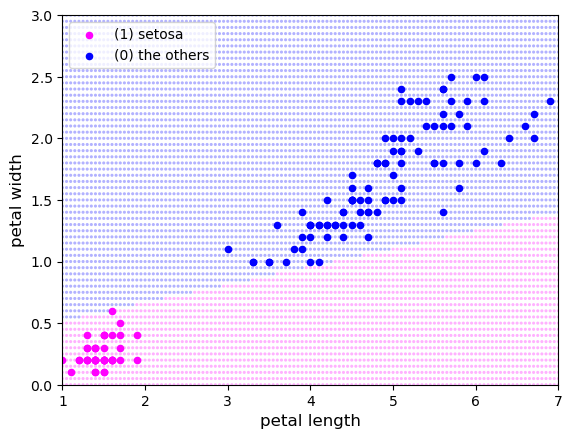

In [ ]:
# 학습표본의 순서를 섞거나 연결 가중치 및 바이어스 초깃값을 정할 때 무작위 수를 이용하고 있으며, 이에 따른 학습 결과는 일정하지 않다.
visualize(p, X_tr, y_tr,
          multi_class = False,
          class_id = labels,
          labels = [1, 0],
          colors = ['magenta', 'blue'],
          xlabel = 'petal length',
          ylabel = 'petal width',
          legend_loc = 'upper left')

학습표본의 순서를 섞거나 연결 가중치 및 바이어스 초깃값을 정할 때 무작위 수를 이용하고 있으며, 이에 따른 학습 결과는 일정하지 않다.